# RQs and their answers

The main research question is _'Can a hybrid recommendation system using metadata perform better than the current recommendation system of NPO Start which uses collaborative filtering?'_. The research is split into three sub-questions:
* RQ1: What is the performance of the current recommendation system?
* RQ2: Can the performance of the current recommendation system be improved by implementing a hybrid recommendation system?
* RQ3: Which metadata features improve the performance of the hybrid recommendation system the most?

### Evaluation
The performance of a recommendation system is assessed by the quality of recommendations. The quality is evaluated by two metrics: mean precision@k (mean p@k) and mean reciprocal rank (MRR).  

* __ Mean Precision@k__ <br>
Mean precision@k is a metric that evaluates the average proportion of top-k recommended items that are relevant to users. A relevant item is an item that was chosen by a user when it was offered in a ribbon. Relevant items are denoted as a true positive (TP) which are positive predicted values. The precision is thus denoted as the total number of predicted positives out of all predicted items. The equation for the precision@k is shown below. 
<img style="width:250px;height:53px;border:0;" src="nr2.png">
The precision@k is evaluated over all recommendations and averaged into the mean precision@k (see below) to evaluate the overall quality of the system.
<img style="width:250px;height:53px;border:0;" src="nr3.png">

* __Mean Reciprocal Rank__ <br>
Mean reciprocal rank is a metric that evaluates the average ranking quality of lists that a model produces. It evaluates how successful the model is in ranking the highest relevant item to users. It is calculated by dividing the best possible rank by the actual rank of the first relevant items and averaging it. 
<img style="width:200px;height:53px;border:0;" src="nr1.png">


The higher the value of the metrics, the better. The version with the highest mean precision has the most success of recommending items that users are interested in, and the version with the highest MRR is most successful in ranking the 
highest relevant item in a personalized manner. 

### Method
A hybrid recommendation system using the Python library LightFM was set up which is a hybrid matrix factorisation model which represents users and items as linear combinations of their content features’ latent factors. A weighted approximate-rank pairwise loss was used which learns to rank the items. The model learns user and item representations from the input data, by using the latent representation approach. It computes recommendations for new items and users, by representing items and users as linear combinations of their content features. 
    Six content features were chosen for the hybrid recommendation system and all possible 63 combinations of these features were incoporated into the LightFM model. These combinations and a model that used no content features were trained on 21 days (1-21 March 2019) of user interaction data from NPO Start and tested on the 22th day. This was done in epochs ranging from 10 to a 100 with intervals of 10.
    
   <img style="width:500px;height:200px;border:0;" src="model_evaluation.png">

### RQ1
_'What is the performance of the current recommendation system?'_

<center>Mean P@5 and MRR of the current recommendation system</center>

| metric   | mean  | std   |
|----------|-------|-------|
| Mean P@k | 0,006 | 0,047 |
| MRR      | 0,009 | 0,066 |
This table shows the mean precision@5 and mean reciprocal rank of the current recommendation system of the NPO Start 'Aanbevolen voor jou' ribbon for users. The metrics indicate that the current recommendation system is not good at recommending items to users and ranking them. 

### RQ2
_'Which metadata features improve the performance of the hybrid recommendation system the most?'_

In [2]:
df = spark.read.parquet('gs://dataproc-jupyter-eileen.npo-data.nl/data/results/results_RUN1').toPandas()

Six metadata variables, namely broadcaster, credits, description, genres, subtitles, title, were chosen as content features for the hybrid recommendation system. This results in 63 combinations of these content features and one additional version that uses no content features. For an example of these combinations see below. 

In [14]:
import pandas as pd
pd.concat([pd.DataFrame(df.sort_values('combi').features.unique()).head(), pd.DataFrame(df.sort_values('combi').features.unique()).tail()])

,0
0,None
1,"('broadcaster',)"
2,"('credits',)"
3,"('description_tfidf',)"
4,"('genres',)"
59,"('broadcaster', 'credits', 'description_tfidf'..."
60,"('broadcaster', 'credits', 'genres', 'title_tf..."
61,"('broadcaster', 'description_tfidf', 'genres',..."
62,"('credits', 'description_tfidf', 'genres', 'ti..."
63,"('broadcaster', 'credits', 'description_tfidf'..."


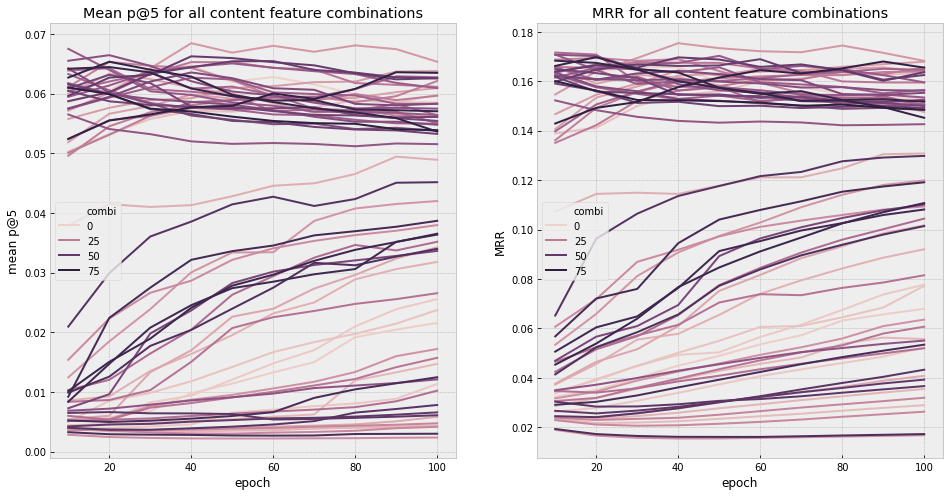

In [4]:
f, axes = plt.subplots(1, 2, figsize=(16,8))
ax = sns.lineplot(x="epoch", y="test_p5",data=df, hue='combi', ax=axes[0])
axes[0].set_title("Mean p@5 for all content feature combinations")
axes[0].set(ylabel='mean p@5')
ax = sns.lineplot(x="epoch", y="test_r-rank",data=df, hue='combi', ax=axes[1])
axes[1].set_title("MRR for all content feature combinations")
axes[1].set(ylabel='MRR')
plt.show()

The figures above display the values for the mean precision@5 and mean reciprocal rank for all the feature combination versions.

<center>Feature combination versions with the highest mean p@5 and MRR</center>

| metric   | version | features                    | value | std      |
|----------|---------|-----------------------------|-------|----------|
| Mean P@5 | 16      | (description_tfidf, genres) | 0,068 | 0,103529 |
| MRR      | 16      | (description_tfidf, genres) | 0,175 | 0,224504 |

This table shows the feature combination versions that achieved the highest mean precision@k and mean reciprocal rank. Version 16, which incorporated the features description TF-IDF and the genres, achieved the highest value for both metrics, thus is the model that produces recommendations with the best performance. 

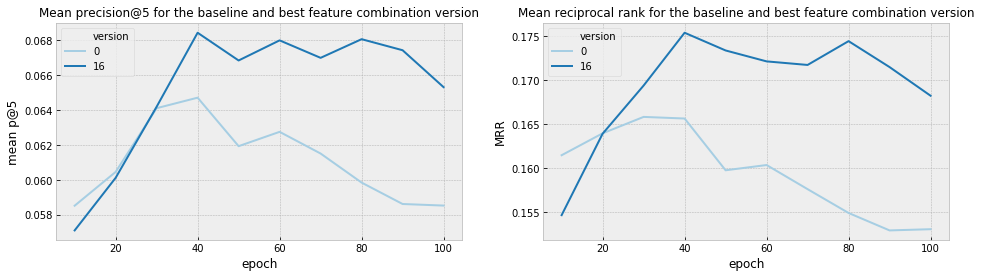

In [5]:
high_base = [0, 16]
df_16 = df[df['version'].isin(high_base)].copy()
f, axes = plt.subplots(1, 2, figsize=(16,4))
ax = sns.lineplot(x="epoch", y="test_p5",data=df_16, hue='version', palette=sns.color_palette("Paired", 2), ax=axes[0])
axes[0].set_title("Mean precision@5 for the baseline and best feature combination version", size=12)
axes[0].set(ylabel='mean p@5')
ax = sns.lineplot(x="epoch", y="test_r-rank",data=df_16, hue='version', palette=sns.color_palette("Paired", 2), ax=axes[1])
axes[1].set_title("Mean reciprocal rank for the baseline and best feature combination version", size=12)
axes[1].set(ylabel='MRR')
plt.show()

The two graphs above show the performance for the best version that used genre and description as content features and the baseline version that used no content features for both metrics. These two versions were tested on the recommendations of 3169 users. It is expected that the version with the highest performance performs better than the baseline. <br>
The average precision of version 0 per user is 0.065 (sd=0.101) and of version 16 per user is 0.068 (sd=0.104). This was tested using a right-tailed paired sample t-test and found that the null hypothesis is rejected (t=94.3, p=0.0), thus the precision in version 16 is significantly better than version 0. <br>
The average rank of version 0 per user is 0.175 (=0.225) and of version 16 per user is 0.166 (=0.217). This was tested using a right-tailed paired sample t-test and found that the null hypothesis is rejected (t=76.3, p=0.0), thus the rank in version 16 is significantly better than version 0. 

### RQ2
_'Can the performance of the current recommendation system be improved by implementing a hybrid recommendation system?'_

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('bmh')
pd.options.display.max_columns = 500

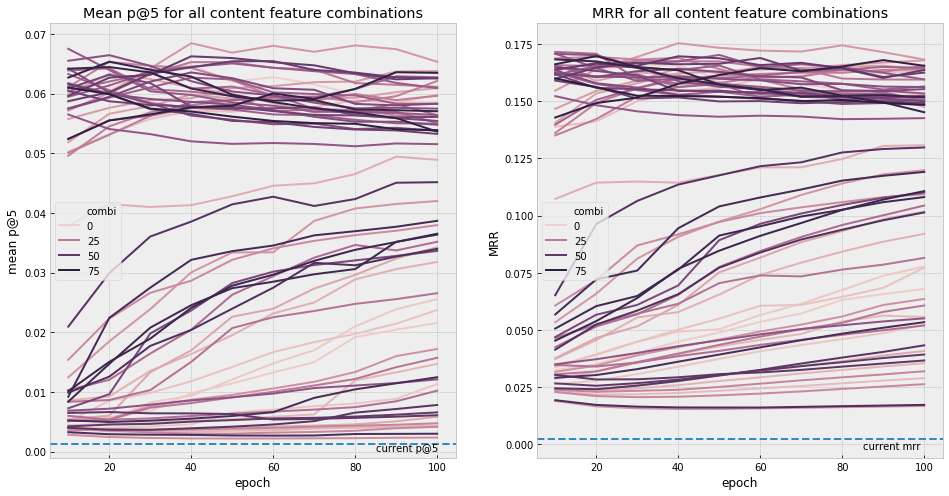

In [5]:
f, axes = plt.subplots(1, 2, figsize=(16,8))
ax = sns.lineplot(x="epoch", y="test_p5",data=df, hue='combi', ax=axes[0])
axes[0].set_title("Mean p@5 for all content feature combinations")
axes[0].set(ylabel='mean p@5')
axes[0].axhline(0.001337, ls='--')
axes[0].text(85, 0.0, "current p@5")
ax = sns.lineplot(x="epoch", y="test_r-rank",data=df, hue='combi', ax=axes[1])
axes[1].set_title("MRR for all content feature combinations")
axes[1].set(ylabel='MRR')
axes[1].axhline(0.002513, ls='--')
axes[1].text(85, -0.002, "current mrr")
plt.show()

The figures above display the values for the mean precision@5 and mean reciprocal rank for all the feature combination versions. The metric values of the current NPO Start recommendation system is indicated by a blue dashed line in the figures. All content feature combinations have higher values for both both metrics perform better than the current system.

The highest performing version with features genre and description (n=3169) was tested against the current recommendation system (n=3142). It is expected that the version with the highest performance performs better than the baseline. <br>
The average precision of version current per user is 0.006 (sd=0.047) and of version 16 per user is 0.068 (sd=0.104). This was tested using a right-tailed two sample t-test and found that the null hypothesis is rejected(t=30.8, p=0.0), thus the precision in version 16 is not significantly better than the current version. <br>
The average rank of version current per user is 0.009 (sd=0.066) and of version 16 per user is 0.166 (sd=0.217). This was tested using a right-tailed two sample t-test and found that the null hypothesis is rejected (t=8.7, p=0.0), thus the rank in version 16 is significantly better than version current. 